In [2]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x1ad70870e50>)

In [3]:
filename = "C:\\Users\\banka\\OneDrive\\Pictures\\Camera Roll\\webcampic.jpg"

In [4]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in C:\Users\banka/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\banka/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [6]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\banka/.cache\torch\hub\intel-isl_MiDaS_master


In [7]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [8]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

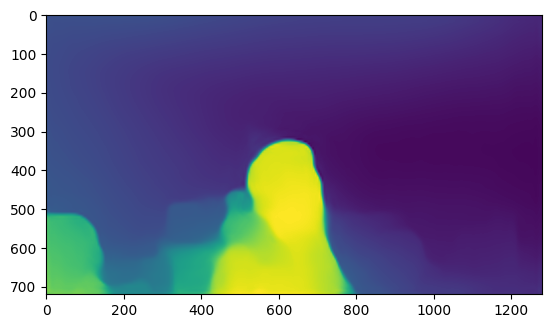

In [9]:
plt.imshow(output)
# plt.show()

In [10]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('Cannot open webcam')
    exit(-1)

while True:
    success, frame = cap.read()

    # Apply transforms
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_batch = transform(img).to(device)

    # Predict and resize to original resolution
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()

    plt.imshow(output)
    plt.pause(0.00001)

    cv2.imshow('Webcam', img)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Keep running until you press `q`
        break

cap.release()
cv2.destroyAllWindows()
plt.show()

In [11]:
# cap = cv2.VideoCapture(0)

# if not cap.isOpened():
#     print('Cannot open webcam')
#     exit(-1)

# # Define the threshold value
# threshold = 0.5

# while True:
#     success, frame = cap.read()

#     # Apply transforms
#     img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     input_batch = transform(img).to(device)

#     # Predict and resize to original resolution
#     with torch.no_grad():
#         prediction = midas(input_batch)

#         prediction = torch.nn.functional.interpolate(
#             prediction.unsqueeze(1),
#             size=img.shape[:2],
#             mode="bicubic",
#             align_corners=False,
#         ).squeeze()

#     output = prediction.cpu().numpy()

#     # Apply a binary threshold to create a mask
#     mask = output > threshold

#     # Apply the mask to the original image
#     masked_img = cv2.bitwise_and(img, img, mask=mask.astype(np.uint8))

#     # Display the masked image and labels
#     cv2.imshow('Webcam', masked_img)

#     if cv2.waitKey(1) & 0xFF == ord('q'):  # Keep running until you press `q`
#         break

# cap.release()
# cv2.destroyAllWindows()


KeyboardInterrupt: 